# Example: Using gcm-filters on gridded surface velocity observations 
In this tutorial we extract and filter gridded surface ocean velocity data. These data (OSCAR zonal ($u$) and meridional ($v$) surface velocities) are provided by NASA PODAAC and represent the synthesis of a collection of near-real-time satellite observations of sea surface height, sea surface temperature, and surface winds. Geostrophic, Ekman, and Stommel shear dynamics are accounted for in the spatially gridded product (surface velocities on a 1/3 degree grid). These data are publically available at [PODAAC](https://podaac.jpl.nasa.gov/dataset/OSCAR_L4_OC_third-deg?ids=Keywords&values=Oceans:Ocean%20Circulation:Ocean%20Currents&provider=PODAAC). Both Taper and Gaussian filter kernels are used in subsequent spatial filtering. Data are packaged into appropriate formats/types as required by gcm-filters. 

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import gcm_filters

## Load gridded satellite data 

In [2]:
# pull from NASA PODAAC 
# one day of OSCAR surface velocities (1/3 degree)
filename = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/oscar/preview/L4/oscar_third_deg/oscar_vel10030.nc.gz'
ds = xr.open_dataset(filename)
KE = 0.5*(ds['u']**2 + ds['v']**2)

/Users/jakesteinberg/anaconda3/envs/gcm_filt/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jakesteinberg/anaconda3/envs/gcm_filt/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


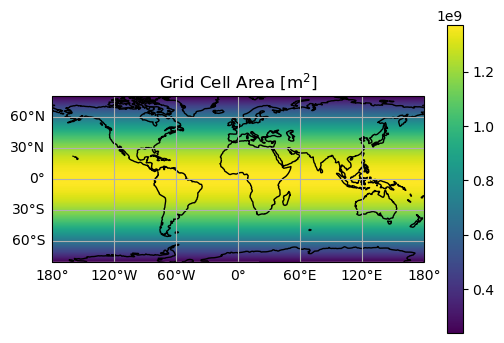

In [3]:
# -- compute cell area -- 
# -- for each lat/lon grid box gcm-filters needs area in same format as du,dv
dy0 = 1852*60*np.abs(ds['latitude'][2].data - ds['latitude'][1].data)
# ** note: dy0 is a constant over the globe ** 
dx0 = 1852*60*np.cos(np.deg2rad(ds['latitude'].data))*(ds['longitude'][2].data - ds['longitude'][1].data) 
area = dy0*np.tile(dx0, (len(ds['longitude'].data),1))
area = np.transpose(area)
dA = xr.DataArray(
    data=area,
    dims=["latitude", "longitude"],
    coords=dict(
    longitude=(["longitude"], ds['longitude'].data), latitude=(["latitude"], ds['latitude'].data),),
)
area_cmap = 'viridis'       # colormap 
f,ax = plt.subplots(1,1,figsize=(6,4),subplot_kw={'projection':ccrs.PlateCarree()})
dA.plot(ax=ax, cmap=area_cmap)
ax.set_title('Grid Cell Area [m$^2$]')
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
plt.show()

In [4]:
# -- wet mask -- 
# -- land = 1, water = 0 -- 
wetMask = xr.where(np.isnan(KE), 0, 1)

In [5]:
# -- call gcm-filters and select desired grid type -- 
gcm_filters.required_grid_vars(gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED)

['area', 'wet_mask']

In [6]:
# -- choose a filtering scale -- 
filter_scale = 3
dx_min = 1
# -- initialze filter object for two filter types -- 
specs = {
    'filter_scale': filter_scale,
    'dx_min': dx_min,
    'grid_type': gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
    'grid_vars': {'area': dA, 'wet_mask': wetMask}
}
# GAUSSIAN 
filter_simple_fixed_factor_G = gcm_filters.Filter(filter_shape=gcm_filters.FilterShape.GAUSSIAN, **specs)
# TAPER 
filter_simple_fixed_factor_T = gcm_filters.Filter(filter_shape=gcm_filters.FilterShape.TAPER, **specs)

### Defining mean and eddy kinetic energy (overbar denotes spatial filter) 

Kinetic Energy (KE) = $\frac{1}{2} \left( u^2 + v^2 \right)$ 
 
Mean Kinetic Energy (MKE) = $\frac{1}{2} \left( \overline{u}^2 + \overline{v}^2 \right)$

Eddy Kinetic Energy (EKE) = $\overline{\frac{1}{2} \left( u^2 + v^2 \right)} - \frac{1}{2} \left( \overline{u}^2 + \overline{v}^2 \right)$

In [7]:
# -- filter velocities, filter KE, and define EKE (for both Gaussian and Taper kernels) -- 
u_filtered_simple_fixed_factor = filter_simple_fixed_factor_G.apply(ds['u'], dims=['latitude', 'longitude'])
v_filtered_simple_fixed_factor = filter_simple_fixed_factor_G.apply(ds['v'], dims=['latitude', 'longitude'])
MKE = 0.5*(u_filtered_simple_fixed_factor**2 + v_filtered_simple_fixed_factor**2).squeeze()
KE_filtered_simple_fixed_factor = filter_simple_fixed_factor_G.apply(KE, dims=['latitude', 'longitude'])

u_filtered_simple_fixed_factor_T = filter_simple_fixed_factor_T.apply(ds['u'], dims=['latitude', 'longitude'])
v_filtered_simple_fixed_factor_T = filter_simple_fixed_factor_T.apply(ds['v'], dims=['latitude', 'longitude'])
MKE_T = 0.5*(u_filtered_simple_fixed_factor_T**2 + v_filtered_simple_fixed_factor_T**2).squeeze()
KE_filtered_simple_fixed_factor_T = filter_simple_fixed_factor_T.apply(KE, dims=['latitude', 'longitude'])

EKE_G = KE_filtered_simple_fixed_factor.squeeze() - MKE
EKE_T = KE_filtered_simple_fixed_factor_T.squeeze() - MKE_T

/Users/jakesteinberg/anaconda3/envs/gcm_filt/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jakesteinberg/anaconda3/envs/gcm_filt/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


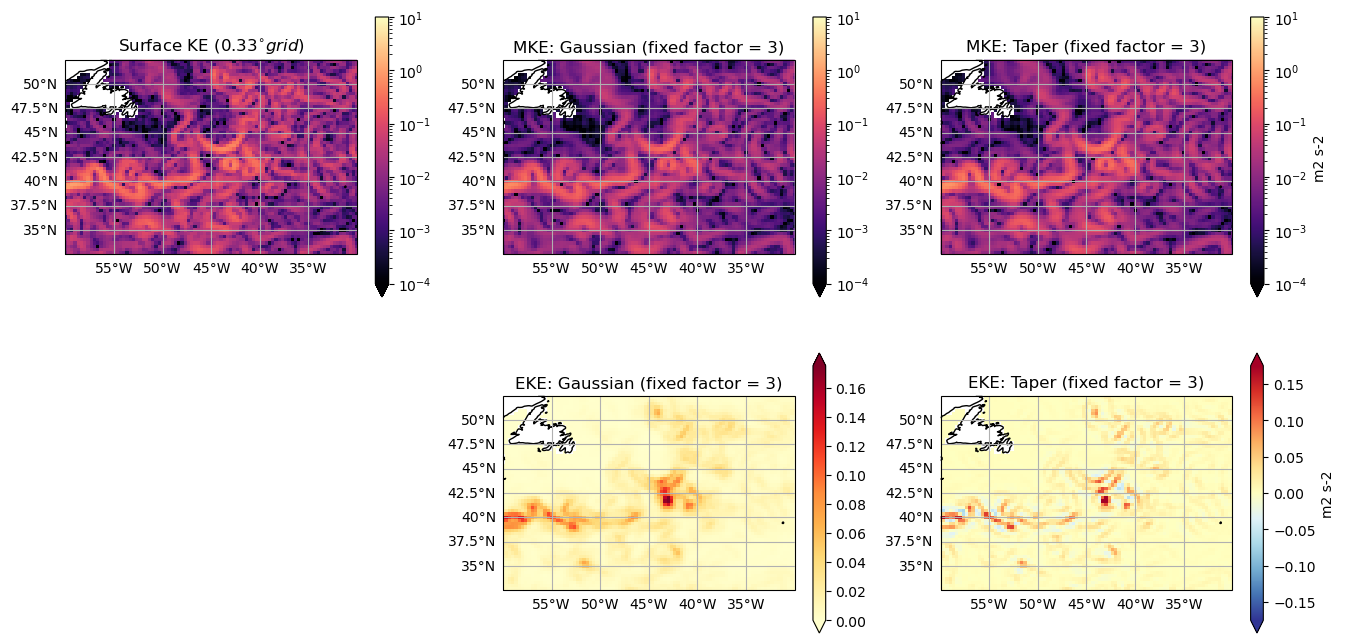

In [8]:
ke_lims = [0.0001, 10]  # colormap limits (m^2 s^(-1))
ke_cmap = 'magma'       # colormap 

# -- PLOT --  
f,ax = plt.subplots(2,3,figsize=(16,8),subplot_kw={'projection':ccrs.PlateCarree()})
KE.plot(ax=ax[0,0], cmap=ke_cmap, norm=LogNorm(vmin=ke_lims[0], vmax=ke_lims[1]))
ax[0,0].set(title='Surface KE (' + \
            str(np.round(np.abs(ds['latitude'][2].data - ds['latitude'][1].data),2)) + '$^{\circ} grid$)')

MKE.plot(ax=ax[0,1], cmap=ke_cmap, norm=LogNorm(vmin=ke_lims[0], vmax=ke_lims[1]))
ax[0,1].set(title='MKE: Gaussian (fixed factor = ' + str(filter_scale) + ')')

MKE_T.plot(ax=ax[0,2], cmap=ke_cmap, cbar_kwargs={'label': 'm2 s-2'}, norm=LogNorm(vmin=ke_lims[0], vmax=ke_lims[1]))
ax[0,2].set(title='MKE: Taper (fixed factor = ' + str(filter_scale) + ')')

EKE_G.plot(ax=ax[1,1], cmap='YlOrRd', vmin=0, vmax=0.175)
ax[1,1].set(title='EKE: Gaussian (fixed factor = ' + str(filter_scale) + ')')

EKE_T.plot(ax=ax[1,2], cmap='RdYlBu_r', cbar_kwargs={'label': 'm2 s-2'}, \
                                     vmin=-0.175, vmax=0.175)
ax[1,2].set(title='EKE: Taper (fixed factor = ' + str(filter_scale) + ')')

gax = ax.flatten()
for i in [0,1,2,4,5]:
    gax[i].coastlines()
    gax[i].set_extent([300, 330, 32.5, 52.5], crs=ccrs.PlateCarree())
    gl = gax[i].gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
f.delaxes(ax[1,0])
plt.show()
# f.savefig('ke_mke_eke.jpg', dpi=500)